# Cas3-Derived Target DNA Degradation Fragments Fuel Primed CRISPR Adaptation

Текст статьи: https://www.cell.com/molecular-cell/fulltext/S1097-2765(16)30364-1 
Файлы с "сырыми" данными: https://www.ebi.ac.uk/ena/data/search?query=PRJEB13999 (ENA)

Риды из "сырых" файлов были очищенны от адаптеров и из них были отобраны только те, которые картируются на последовательность используемой в эксперименте плазмиды. Последовательность плазмиды не была опубликована в статье, но ее предоставили нам коллеги.

Данный скрипт предназначен для сортировки и обработки очищенных ридов, записанных в SAM файл. Риды - результат секвенирования линейных молекул ДНК, полученных в результате специфичного (предположительно) разрезания кольцевой плазмиды каспазой Cas3. Для определения сайтов разрезания нам требовалось определить позиции на которые картируются 5'-концы ридов и посчитать частоты оснований, встречающихся на этих позициях в плазмиде.

Для выполнения задачи требуются модули: numpy, pandas, matplotlib.pyplot, seaborn и функция Counter из модуля collections.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

При считывании SAM файла была пропущена первая строка с заглавиями столбцов. Далее считанные строки были разбиты по табулятору. (На выходе имеем список списков, где в каждом вложенном списке индекс элемента соответствует номеру столбца в исходном файле)

In [14]:
with open('Galaxy84_Filter_SAM_or_BAM,_outp.sam') as samfile:
    for _i in range(3):
        samfile.readline()
    lines = samfile.readlines()
    
columns = map(lambda x: x.split('\t'), lines)

Во 2м столбце SAM файла записывается информация о риде с использованием двоичного маскирования. Побитовый разбор можно посмотреть здесь: https://davetang.org/wiki/tiki-index.php?page=SAM.

Используя побитовый "and" мы отфильтровали риды по их принадлежности к нужным нам классам. То есть проверялось, что на нужной позиции в нашей записи стоит 0 или 1.

Позиции следующие: ноль на позиции 0x0004 означает, что рид картировался на референсную последовательность; ноль на позиции 0x0008 означает, что рид парный; то, что на позициях 0x0010 и 0x0020 стоят разные числа, означает, что и рид и его "пара" выровнялись на разные цепи.

In [15]:
filter1 = filter(lambda x: (int(x[1]) & 0x0004) == 0, columns)
# Find only mapped sequences

filter2 = filter(lambda x: (int(x[1]) & 0x0008) == 0, filter1)
# Find only pair mapped reads

filter3 = list(filter(lambda x: ((int(x[1]) & 0x0010) == 0) != ((int(x[1]) & 0x0020) == 0),
                      filter2))
# Find reads itself and it's mate mapped within the differnt chain

Для дальнейшей работы потребовалось ввести функцию, которая будет сортировать риды по их принадлежности к типам f1 (первый рид в паре выравнивается на прямую цепь), f2 (второй рид в паре выравнивается на прямую цепь), r1 (первый рид в паре выравнивается на обратную цепь), r2 (второй рид в паре выравнивается на обратную цепь). 

In [16]:
# Sort readings based on how they are mapped

def typy(a):
    i = int(a[1])
    if (i & 0x10) and (i & 0x40):
        reverse_first.append(a)
    elif (i & 0x20) and (i & 0x40):
        forward_first.append(a)
    elif (i & 0x10) and (i & 0x80):
        reverse_second.append(a)
    elif (i & 0x20) and (i & 0x80):
        forward_second.append(a)

Риды сортируются и записываются в 4 разных списка.

In [17]:
reverse_first = []
forward_first = []
reverse_second = []
forward_second = []

for a in filter3:
    typy(a)

Далее требовалось рассчитать покрытие каждой позиции в последовательности плазмиды КОНЦАМИ ридов. В SAM файле записаны координаты начал ридов, но, если для f1 и f2 можно брать непосредственно эти числа, то для r1 и r2 (т.к. это получается координата 3'-конца) нужно прибавить к указанной координате начала длину рида (вычисляется как длина строки с последовательностью рида). В виде комментариев внутри функций изображены рассматриваемые случаи, звездочками помечены первые риды в паре.

Функция r_starts работает с обратной цепью. Она возвращает словарь, в котором ключами являются позиции, а соответствующими значениями то, сколько концов ридов попадает на соответствующую позицию.

In [18]:
def r_starts():
    d = {}
    for a in forward_second:
        p = int(a[3]) # начало рида - не правильно - fixed
        # 2|----->               *
        #                 <!-----|1 non target
        d[p] = d.get(p,0) + 1
    for a in reverse_first:
        # 2|-----!>
        #  *               <------|1
        p = int(a[3]) + len(a[9]) - 1 # не правильно - fixed
        d[p] = d.get(p,0) + 1
    return d

Функция f_starts работает с прямой цепью. Она также возвращает словарь, в котором ключами являются позиции, а соответствующими значениями то, сколько концов ридов попадает на соответствующую позицию.

In [19]:
def f_starts():
    d = {}
    for a in forward_first:
        # 1|---!> 
        #  *        <----|2
        p = int(a[3]) # все ок
        d[p] = d.get(p,0) + 1
    for a in reverse_second:
        # 1|----->        *
        #           <!----|2
        p = int(a[3]) + len(a[9]) - 1 # все ок
        d[p] = d.get(p,0) + 1
    return d

Получены вышеописанные словари: 1й для прямой и 2й для обратной цепи. Далее они отсортированы в порядке убывания значений и распечатаны.

In [20]:
counter1 = f_starts()
counter2 = r_starts()

In [21]:
print(sorted(counter1.items(), key = lambda x: -x[1]))

[(1124, 4676), (1118, 850), (1121, 815), (1197, 417), (2636, 362), (1125, 333), (64, 289), (1196, 275), (1199, 240), (2789, 240), (1198, 231), (2479, 216), (2480, 199), (1214, 194), (1150, 193), (1126, 190), (1981, 185), (2460, 185), (1242, 175), (1195, 166), (1226, 160), (1223, 153), (1431, 152), (2093, 151), (2509, 150), (1224, 136), (2343, 134), (2478, 129), (1213, 123), (1241, 120), (1240, 117), (1189, 116), (2458, 114), (1152, 112), (2345, 110), (1225, 109), (2527, 108), (2601, 102), (1188, 94), (1187, 92), (1194, 89), (289, 88), (1145, 88), (1231, 88), (1239, 87), (1474, 87), (1123, 84), (1183, 83), (1227, 83), (1237, 78), (1184, 77), (1232, 77), (1216, 76), (1257, 75), (1164, 74), (1230, 74), (2094, 74), (1186, 73), (1222, 72), (1185, 71), (1238, 69), (2315, 69), (1193, 68), (1236, 68), (263, 67), (2599, 67), (1165, 64), (1192, 64), (2814, 64), (1212, 61), (1229, 61), (1639, 61), (1191, 60), (1215, 60), (2502, 59), (2557, 59), (2350, 58), (2506, 58), (1336, 57), (2556, 57), (119

In [22]:
print(sorted(counter2.items(), key = lambda x: -x[1]))

[(2403, 3077), (2279, 776), (153, 616), (63, 597), (29, 406), (32, 313), (2343, 298), (2342, 286), (940, 247), (2424, 236), (150, 208), (34, 198), (2235, 182), (513, 175), (2731, 175), (2422, 160), (2708, 154), (148, 151), (2236, 147), (2344, 142), (10, 133), (2727, 129), (2212, 124), (1461, 116), (2655, 104), (2007, 103), (2308, 102), (9, 101), (1350, 98), (2254, 95), (2237, 94), (189, 89), (2224, 86), (2334, 86), (116, 81), (897, 81), (69, 80), (1430, 78), (62, 77), (15, 74), (503, 73), (2345, 73), (115, 71), (61, 70), (2277, 68), (193, 67), (511, 67), (2245, 67), (2780, 64), (8, 61), (2653, 61), (64, 60), (14, 58), (128, 57), (2211, 57), (2348, 57), (11, 56), (2238, 56), (2350, 56), (1351, 55), (2449, 55), (2409, 53), (2654, 53), (155, 51), (159, 51), (2055, 51), (2309, 51), (2341, 51), (16, 49), (2470, 49), (1384, 48), (2239, 48), (157, 47), (2225, 47), (65, 46), (870, 45), (467, 43), (884, 43), (2249, 43), (2352, 43), (2351, 42), (200, 41), (1996, 41), (2317, 41), (2445, 41), (12,

Ниже построены гистограммы, иллюстрирующие полученные данные. Ось абсцисс соответствует последовательности плазмиды (5' -> 3'), ось ординат - частоте встречаемости концов ридов на каждой позиции.

In [23]:
len_plasmid = max(max(counter2.keys()), max(counter1.keys()))
positions1 = list(map(lambda x: counter1.get(x, 0), range(len_plasmid + 1)))
positions2 = list(map(lambda x: counter2.get(x, 0), range(len_plasmid + 1)))

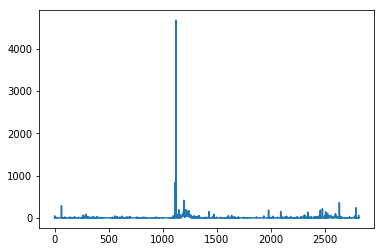

In [24]:
pd.Series(np.array(positions1)).plot()

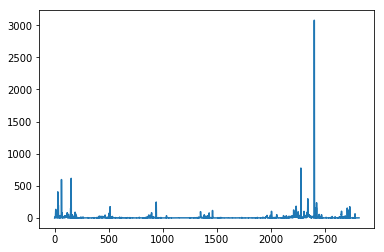

In [25]:
pd.Series(np.array(positions2)).plot()

Далее требовалось найти паттерны сайтов рестрикции, а для этого нужно было понять, какие нуклеотиды окружают наиболее покрытые концами ридов позиции.
В статье для визуализации результатов использовались теплокарты. Мы решили также использовать теплокарты и для того, чтобы их построить, отобрали 100 самых покрытых позиций на обеих цепях, исключая 3 наиболее покрытые.

In [26]:
# choosing best 100 start positions

first100_f_starts = dict([(1197, 417), (2636, 362), (1125, 333), (64, 289), (1196, 275), (1199, 240), (2789, 240), (1198, 231), (2479, 216), (2480, 199), (1214, 194), (1150, 193), (1126, 190), (1981, 185), (2460, 185), (1242, 175), (1195, 166), (1226, 160), (1223, 153), (1431, 152), (2093, 151), (2509, 150), (1224, 136), (2343, 134), (2478, 129), (1213, 123), (1241, 120), (1240, 117), (1189, 116), (2458, 114), (1152, 112), (2345, 110), (1225, 109), (2527, 108), (2601, 102), (1188, 94), (1187, 92), (1194, 89), (289, 88), (1145, 88), (1231, 88), (1239, 87), (1474, 87), (1123, 84), (1183, 83), (1227, 83), (1237, 78), (1184, 77), (1232, 77), (1216, 76), (1257, 75), (1164, 74), (1230, 74), (2094, 74), (1186, 73), (1222, 72), (1185, 71), (1238, 69), (2315, 69), (1193, 68), (1236, 68), (263, 67), (2599, 67), (1165, 64), (1192, 64), (2814, 64), (1212, 61), (1229, 61), (1639, 61), (1191, 60), (1215, 60), (2502, 59), (2557, 59), (2350, 58), (2506, 58), (1336, 57), (2556, 57), (1190, 56), (1261, 56), (2555, 56), (1103, 54), (1114, 54), (1609, 54), (1219, 53), (1221, 53), (2481, 53), (2516, 53), (1228, 52), (1259, 51), (1292, 51), (1182, 50), (1200, 50), (2309, 50), (2540, 50), (1, 49), (297, 48), (559, 48), (1253, 48), (1206, 47), (1218, 47)])
good_starts_f = first100_f_starts.keys() #list of positions in f

first100_r_starts = dict([(63, 597), (29, 406), (32, 313), (2343, 298), (2342, 286), (940, 247), (2424, 236), (150, 208), (34, 198), (2235, 182), (513, 175), (2731, 175), (2422, 160), (2708, 154), (148, 151), (2236, 147), (2344, 142), (10, 133), (2727, 129), (2212, 124), (1461, 116), (2655, 104), (2007, 103), (2308, 102), (9, 101), (1350, 98), (2254, 95), (2237, 94), (189, 89), (2224, 86), (2334, 86), (116, 81), (897, 81), (69, 80), (1430, 78), (62, 77), (15, 74), (503, 73), (2345, 73), (115, 71), (61, 70), (2277, 68), (193, 67), (511, 67), (2245, 67), (2780, 64), (8, 61), (2653, 61), (64, 60), (14, 58), (128, 57), (2211, 57), (2348, 57), (11, 56), (2238, 56), (2350, 56), (1351, 55), (2449, 55), (2409, 53), (2654, 53), (155, 51), (159, 51), (2055, 51), (2309, 51), (2341, 51), (16, 49), (2470, 49), (1384, 48), (2239, 48), (157, 47), (2225, 47), (65, 46), (870, 45), (467, 43), (884, 43), (2249, 43), (2352, 43), (2351, 42), (200, 41), (1996, 41), (2317, 41), (2445, 41), (12, 40), (885, 40), (2260, 40), (2356, 40), (1966, 39), (2656, 39), (110, 38), (465, 38), (1386, 38), (2005, 38), (2335, 38), (2349, 38), (13, 37), (47, 36), (112, 36), (2118, 36), (2357, 36), (2730, 36)])
good_starts_r = first100_r_starts.keys() #list of positions in r

Для дальнейшей работы определяется функция, строящая комплементарную цепочку для последовательности плазмиды из FASTA файла, и вырезающая из этой последовательности слова длины 6 (3 нуклеотида справа и 3 слева от позиции, хорошо покрытой концами ридов).

In [27]:
#convert position to bases for r chain

def pos_to_bases_r(fastafile, good_starts):
    with open (fastafile, 'r') as inp:
        inp.readline()
        string = ''
        for line in inp:
            line = line.strip()
            string = string + line
    genome_reverse = string[::-1]
    genome_rev = list(map(lambda x: {'T':'A', 'A':'T', 'C':'G', 'G':'C'}[x], genome_reverse))
    words= [string[el-3:el+4] for el in good_starts if len(string[el-3:el+4]) == 7] 
    return words


И функция, вырезающая из прямой последовательности слова длины 6 (3 нуклеотида справа и 3 слева от позиции, хорошо покрытой концами ридов).

In [28]:
#convert position to bases for f chain
def pos_to_bases_f(fastafile, good_starts):
    with open (fastafile, 'r') as inp:
        inp.readline()
        string = ''
        for line in inp:
            line = line.strip()
            string = string + line
    words= [string[el-3:el+4] for el in good_starts if len(string[el-3:el+4]) == 7] 
    return words


Получили список искомых слов для прямой и обратной цепей.

In [30]:
words_f = pos_to_bases_f("pGFP-PS8.fa", good_starts_f)
words_r = pos_to_bases_r("pGFP-PS8.fa", good_starts_r)

Вводится функция для подсчета частоты встречаемости букв на каждой позиции полученных словах.

In [32]:
#count bases in words

def gen_pos(words):
    list_of_dict = []
    for i in range(7):
        index_list = [el[i] for el in words]
        count = Counter(index_list)
        list_of_dict.append(count)
    return list_of_dict


Все посчитано.

In [33]:
list_of_dict_f = gen_pos(words_f)
list_of_dict_r = gen_pos(words_r)

Вводится функция для создания теплокарты и, собственно, строятся теплокарты, иллюстрирующие результаты работы.

In [34]:
# Create heatmap

def heatmap(list_of_dict):
    df = pd.DataFrame(list_of_dict)
    df = df.rename(index={0: 1, 1: 2, 2:3, 3:4, 4:5, 5:6, 6:7})
    sns.heatmap(df)

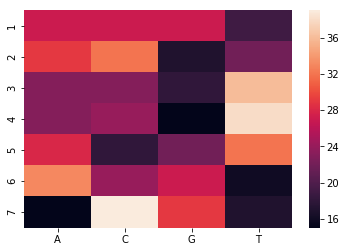

In [35]:
heatmap(list_of_dict_r)

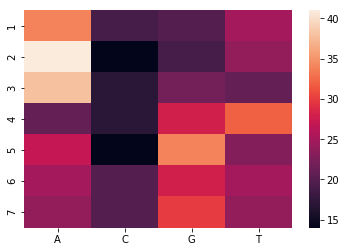

In [36]:
heatmap(list_of_dict_f)